## Normalizing Flows - Exercise 6.
### Daniel Aibinder 318239639, Yonathan Dovgolevsky 327709648

In [1]:
## Standard libraries
import os
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

C:\Users\Danny\AppData\Local\Temp\ipykernel_31564\3028478413.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Using device cuda:0


<Figure size 640x480 with 0 Axes>

In [2]:
def add_noise(sample):
    sample = (sample * 255).to(torch.float) # Convert to float and scale to [0, 255]
    noise = torch.rand_like(sample) # Uniform noise in [0, 1]
    noisy_sample = sample + noise
    noisy_sample = noisy_sample / 255.0 # Scale back to [0, 1]
    noisy_sample = torch.clamp(noisy_sample, 0, 1) # Ensure that the values are still in [0, 1]
    return noisy_sample

def flatten_image(image):
    return image.view(-1)

# Transformations: Convert to tensor, add noise and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    add_noise,
    flatten_image
])


# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False)

Seed set to 42


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.214399e-07..128.0].


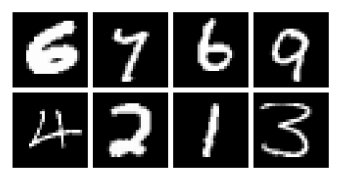

In [3]:
def show_imgs(imgs):
    imgs = [img.view(1, 28, 28) for img in imgs] #unflatten images
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, input_dim // 8),
            nn.ReLU(),
            nn.Linear(input_dim // 8, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, input_dim)
        )

    def forward(self, x):
        self.to(x.device)
        return self.layers(x)

class NormalizingFlowLayer(nn.Module):
    def __init__(self, input_dim):
        super(NormalizingFlowLayer, self).__init__()
        self.input_dim = input_dim
        self.mlp = MLP(input_dim)
    
    def forward(self, x1, x2):
        s = self.mlp(x1)
        z1 = x1 * torch.exp(s)
        z = torch.cat([z1, x2], dim=1)
        log_det_jacobian = s.sum(dim=1)
        return z, log_det_jacobian
    
    def inverse(self, z1, z2):
        s = self.mlp(z1)
        x1 = z1 / torch.exp(s)
        x = torch.cat([x1, z2], dim=1)
        return x


class NormalizingFlowModel(pl.LightningModule):
     
    def __init__(self, input_dim, num_flows):
        super().__init__()
        self.save_hyperparameters()
        self.flows = nn.ModuleList([NormalizingFlowLayer(input_dim // 2) for _ in range(num_flows)])
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)

    
    def forward(self, x):
        log_det_jacobian = 0
        alternate = False
        for flow in self.flows:
            x1, x2 = x.chunk(2, dim=1)
            if alternate:
                x1, x2 = x2, x1
            x, ldj = flow(x1, x2)
            log_det_jacobian += ldj
            alternate = not alternate
        return x, log_det_jacobian
    
    def inverse(self, z):
        alternate = False
        for flow in reversed(self.flows):
            z1, z2 = z.chunk(2, dim=1)
            if alternate:
                z1, z2 = z2, z1
            x = flow.inverse(z1, z2)
            alternate = not alternate
        return x
    
    def calc_likelihood(self, x):
        z, log_det_jacobian = self.forward(x)
        log_pz = self.prior.log_prob(z).sum(dim=1)
        return log_pz + log_det_jacobian

    @torch.no_grad()
    def sample(self, sample_shape):
        z = self.prior.sample(sample_shape).to(device)
        x = self.inverse(z)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, _ = batch
        log_likelihood = self.calc_likelihood(x).mean()
        loss = -log_likelihood
        self.log('train_log_likelihood', log_likelihood)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, _ = batch
        log_likelihood = self.calc_likelihood(x).mean()
        loss = -log_likelihood
        self.log('val_log_likelihood', log_likelihood)
        return loss

    def test_step(self, batch, batch_idx):
        x, _ = batch
        log_likelihood = self.calc_likelihood(x).mean()
        loss = -log_likelihood
        self.log('test_log_likelihood', log_likelihood)
        return loss



In [5]:
def train_model(use_pretrained = False, pretrained_path = "", **kwargs):
    logger = TensorBoardLogger("tb_logs", name="Flows-ex6")
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "Flows-ex6"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         logger = logger,
                         max_epochs=150,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_log_likelihood"),
                                    LearningRateMonitor("epoch")])
    result = None

    # Check whether pretrained model exists. If yes, load it and skip training
    if os.path.isfile(pretrained_path) and use_pretrained:
        print("Found pretrained model, loading...")
        model = NormalizingFlowModel.load_from_checkpoint(pretrained_path)
        ckpt = torch.load(pretrained_path, map_location=device)
        result = ckpt.get("result", None)
    else:
        model = NormalizingFlowModel(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    model = model.to(device)

    if result is None:
        # Test best model on validation and test set
        val_result = trainer.test(model, val_loader, verbose=False)
        test_result = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "val": val_result}
    return model, result

In [6]:
#All graphs taken from tensorboard

# %load_ext tensorboard
# %tensorboard --logdir tb_logs

In [7]:
# QUESTION 1 TRAIN
pretrained_path = "tb_logs//Flows-ex6//version_0//checkpoints//epoch=0-step=390.ckpt"
model, result = train_model(input_dim = 28*28, num_flows = 4, use_pretrained=False, pretrained_path=pretrained_path)
test_res = result["test"][0]
print("test_log_likelihood: %4.3f" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_log_likelihood"]))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | flows | ModuleList | 579 K 
-------------------------------------
579 K     Trainable params
0         Non-trainable params
579 K     Total params
2.318     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

test_log_likelihood: -7317998.000


## Results
<!-- <img src="https://raw.githubusercontent.com/daiyral/ex5/main/plots/q1/train_elbo.png" alt="Training Loss (Non-Causal)" width="1000"/> -->

Seed set to 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


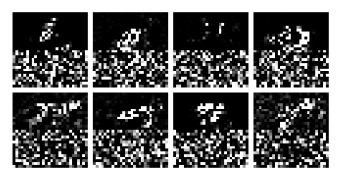

In [12]:
pl.seed_everything(2)
samples = model.sample(sample_shape=(8, 28*28))
show_imgs(samples.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.6205007e-06..128.0].


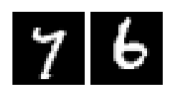

AttributeError: 'NormalizingFlowModel' object has no attribute 'encoder'

In [11]:
def q2(i, j):
    im1, im2 = train_set[i][0], train_set[j][0]
    show_imgs([im1, im2])
    (mu1, log_variance1), (mu2, log_variance2) = model.encoder(im1.unsqueeze(1)), model.encoder(im2.unsqueeze(1))
    for i in range(0, 10):
        mu, log_variance = mu1 * (1 - i/10) + mu2 * i/10, log_variance1 * (1 - i/10) + log_variance2 * i/10
        z = model.latent_sample(mu.unsqueeze(0), log_variance.unsqueeze(0))
        reconstructed = model.decoder(z)
        show_imgs(reconstructed.cpu().detach())
q2(1, 2)
q2(2, 3)
q2(5, 6)